## **1. Preparation**

### 1.1 Install necessary packages

In [1]:
# List all installed packages
# !pip list

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm



In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### 1.2 Unzip data from google drive

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
# Extract files to the local environment and suppress the output
%%capture
!unzip -u "/content/gdrive/My Drive/Breast_cancer_detection/Data/data.zip" -d "/content/Breast_cancer"

### 1.3 Explore data structure

In [5]:
# Find my current path
import os
cwd = os.getcwd()
print (cwd)

/content


In [6]:
# Find the number of patients we have
base_path = os.path.join(cwd, "Breast_cancer", "IDC_regular_ps50_idx5/")
folder = listdir(base_path)
len(folder)

279

In [8]:
# Our algorithm needs to decide whether an image patch contains IDC or not. Consequently not the whole patient tissue slice but the single patches have to be considered as input to our algorithm
# Calculate the total number of patches we have
total_images = 0
for n in range(len(folder)):
  patient_id = folder[n]
  for c in [0, 1]:
    patient_path = base_path + patient_id
    class_path = patient_path + "/" + str(c) + "/"
    subfiles = listdir(class_path)
    total_images += len(subfiles)

#total_images: 277524


In [9]:
#Store the image_path, patient_id and the target for each patch of the image    // For loop, takes long time; think about how to optimize
data = pd.DataFrame(index=np.arange(0, total_images), columns=['patient_id', 'path', 'target'])

k = 0
for i in range(len(folder)):
  patient_id = folder[i]
  patient_path = base_path + patient_id
  for c in [0, 1]:
    class_path = patient_path + "/" + str(c) + "/"
    subfiles = listdir(class_path)
    # Store image patches
    for m in range(len(subfiles)):
      image_path = subfiles[m]
      data.iloc[k]['path'] = class_path + image_path
      data.iloc[k]['target'] = c
      data.iloc[k]['patient_id'] = patient_id
      k += 1

In [ ]:
data.shape

(277524, 3)

In [ ]:
data.head()

patient_id                                               path target
0      14081  /content/Breast_cancer/IDC_regular_ps50_idx5/1...      0
1      14081  /content/Breast_cancer/IDC_regular_ps50_idx5/1...      0
2      14081  /content/Breast_cancer/IDC_regular_ps50_idx5/1...      0
3      14081  /content/Breast_cancer/IDC_regular_ps50_idx5/1...      0
4      14081  /content/Breast_cancer/IDC_regular_ps50_idx5/1...      0

## **2. Exploratory analysis**

### 2.1 Basic statistic analysis

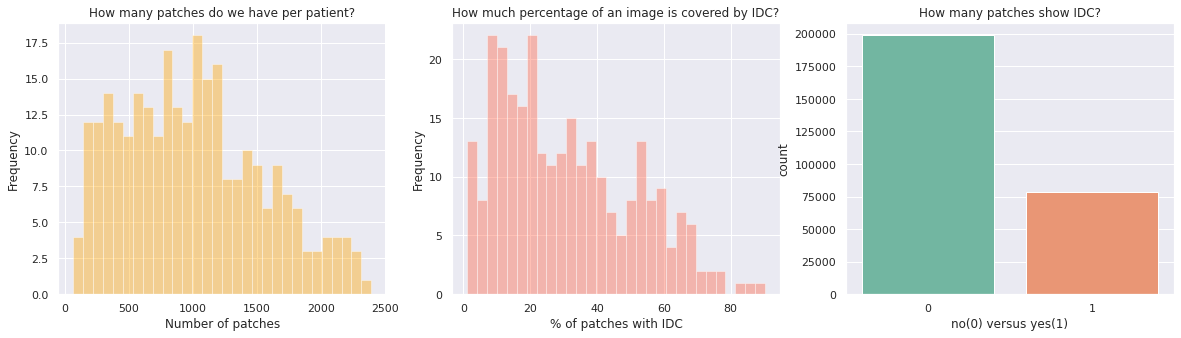

In [ ]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

Insights


1.   The number of image patches per patient varies a lot! This leads to the questions **whether all images show the same resolution of tissue cells or if this varies patients**
2.   Some patients have more than 80% patches that show IDC! **Does a tissue slice per patient cover the whole region of interest?**
3.   The **classes of IDC versus no IDC are imbalanced!** We have to check this again after setting up a validation strategy and find a strategy to deal with class weights.



### 2.2 Visualize cancer patches

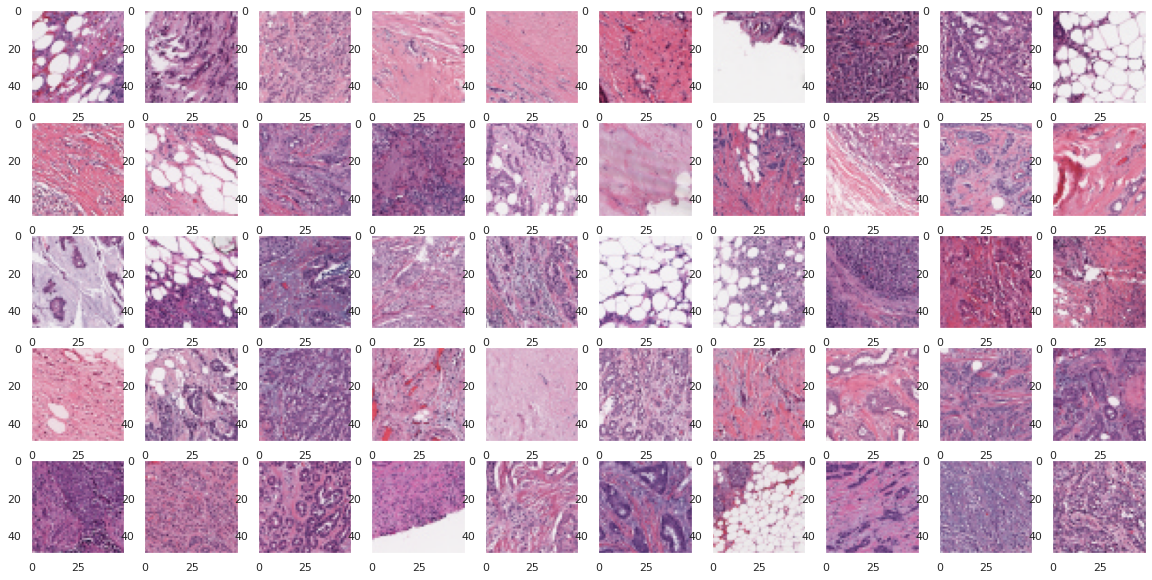

In [ ]:
# Visualize cancer patches
data.target = data.target.astype(np.int)

pos_selection = np.random.choice(data[data.target == 1].index.values, size = 50, replace = False)
neg_selection = np.random.choice(data[data.target == 0].index.values, size = 50, replace = False)

fig, ax = plt.subplots(5, 10, figsize = (20, 10))
for n in range(5):
  for m in range(10):
    idx = pos_selection[m + 10*n]
    image = imread(data.loc[idx, "path"])
    ax[n, m].imshow(image)
    ax[n, m].grid(False)

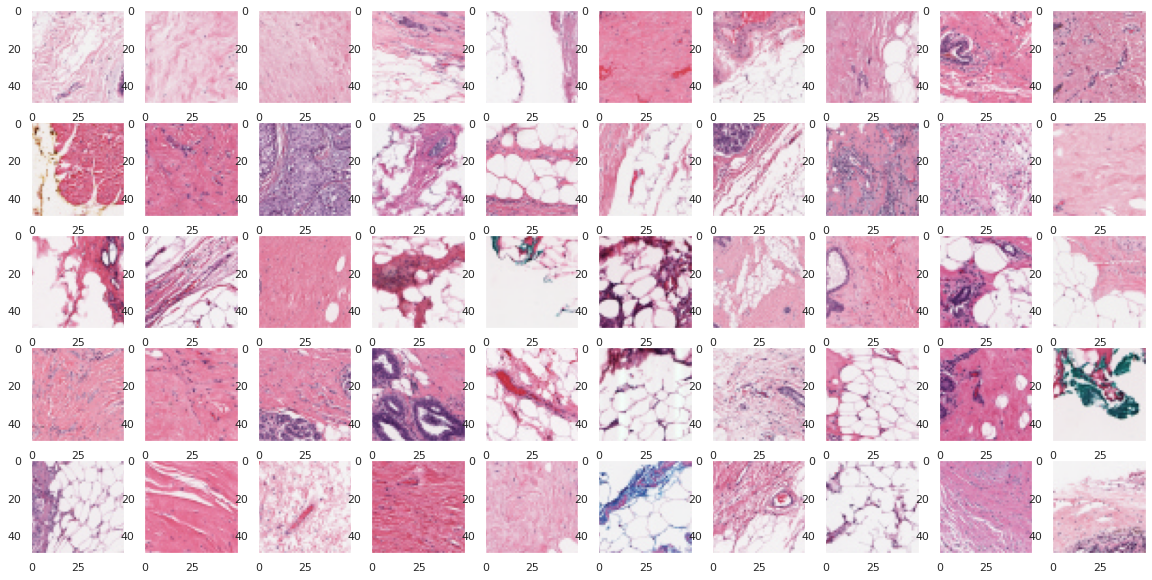

In [ ]:
#   Visualize healthy patches
fig, ax = plt.subplots(5, 10, figsize = (20, 10))
for n in range(5):
  for m in range(10):
    idx = neg_selection[m + 10*n]
    image = imread(data.loc[idx, "path"])
    ax[n, m].imshow(image)
    ax[n, m].grid(False)

Insights


*   Patches with cancer look **more violet** and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue? Some of the healthy patches are very violet colored too!
*   Would be very interesting and insightful to hear what criteria are important for a pathologist
*   Assume that the wholes in the tissue belong to the mammary ducts where the milk can flow through





### 2.3 Visualize the whole breast tissue
We have to extract all coordinates of image patches that are stored in the image names. Then we can use coordinates to reconstruct the whole breast tissue of a patient. This way we can also explore how diseased tissue looks like compared to healthy ones. To simplify this task, let's write a method that takes a patient and outcomes a dataframe with coordinates and targets.

In [10]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [ ]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  2551  2151       0  /content/Breast_cancer/IDC_regular_ps50_idx5/1...
1   601   901       0  /content/Breast_cancer/IDC_regular_ps50_idx5/1...
2  2951  1201       0  /content/Breast_cancer/IDC_regular_ps50_idx5/1...
3   651   251       0  /content/Breast_cancer/IDC_regular_ps50_idx5/1...
4  1051  1951       0  /content/Breast_cancer/IDC_regular_ps50_idx5/1...

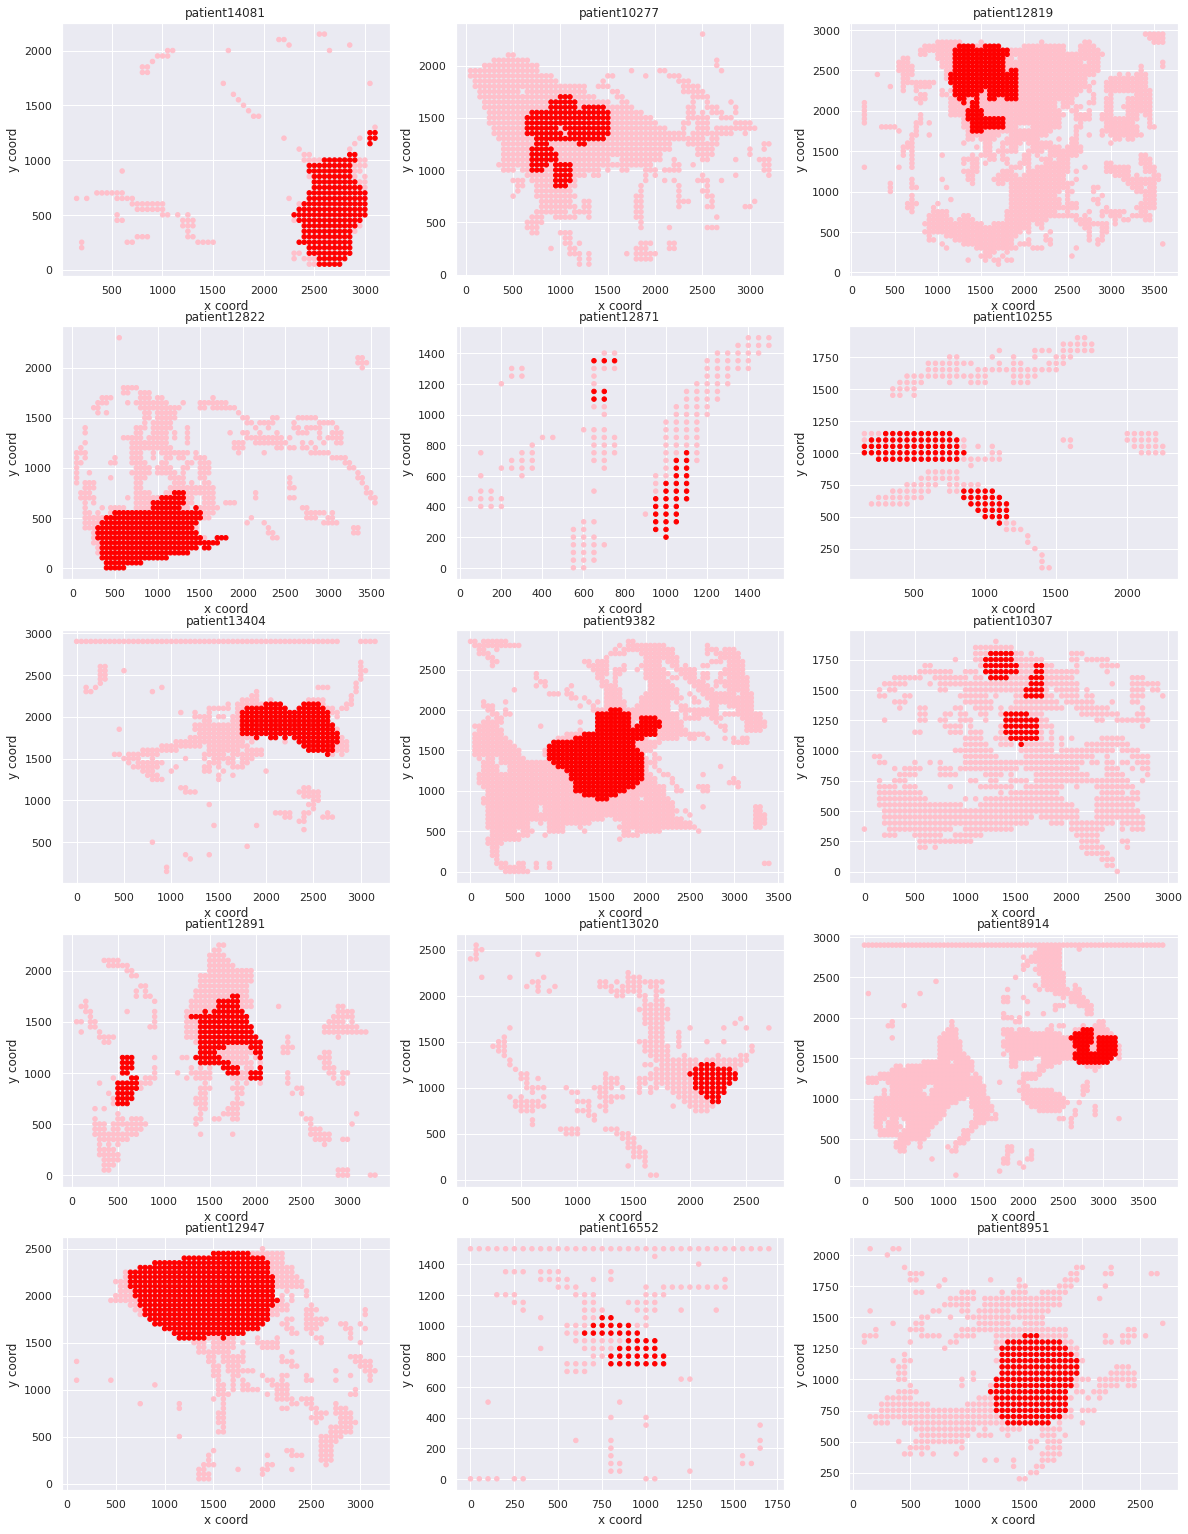

In [ ]:
# Binary target visualization per tissue slice
fig, ax = plt.subplots(5, 3, figsize = (20, 27))
colors = ['pink', 'red']

patient_ids = data.patient_id.unique()
for n in range(5):
  for m in range(3):
    patient_id = patient_ids[m + 3*n]
    example_df = get_patient_dataframe(patient_id)

    ax[n, m].scatter(example_df.x.values, example_df.y.values, c = example_df.target.values, cmap = ListedColormap(colors), s = 20)
    ax[n, m].set_title("patient" + patient_id)
    ax[n, m].set_xlabel("x coord")
    ax[n, m].set_ylabel("y coord")

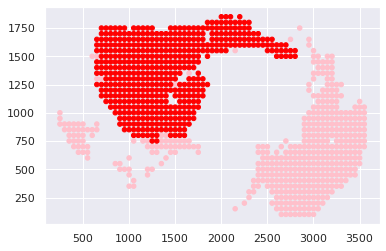

In [ ]:
# Test code: compare results to the notebook
test_patient_id = "14190"
test_df = get_patient_dataframe(test_patient_id)

plt.scatter(test_df.x.values, test_df.y.values, c = test_df.target.values, cmap = ListedColormap(colors), s = 20)


Insights


*   Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation
*   Reading the paper, that seems to be related to this data or could also be part of the preprocessing



In [11]:
# Reconstruct the breast tissue images
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])          
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            
            if pred_df is not None:               
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

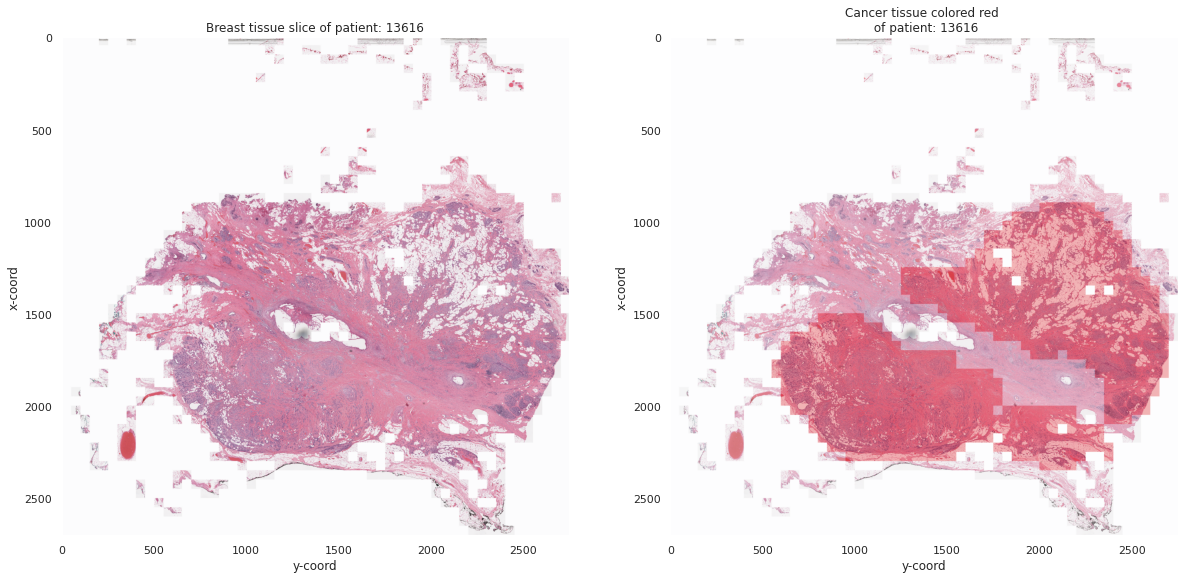

In [ ]:
# Show the example patient with id 13616
patient_id = "13616"
grid, mask, broken_patches, mask_proba = visualise_breast_tissue(patient_id)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("x-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

Insights


*   The image on the left is shown without target information. The image on the right shows the same tissue but cancer is stained with intensive red color.
*   Comparing both images, it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color



## **3. Set up the dataset**

In [12]:
# Settings
batch_size = 32
num_classes = 2

torch.manual_seed(0)
np.random.seed(0)


### 3.1 Validation strategy
A better idea could be to cluster patients with dependence on the size of the tumor, the number of total patches and statistical quantitites of area covered by the patches. The reason is that we would like to have test patients that cover a broad range of possible variations.

In [ ]:
# Validation starting with 30% test and 70% for training and developing
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 8.5+ MB


In [13]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients, test_size = 0.3, random_state = 0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size = 0.5, random_state = 0)

print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)
print(len(train_ids), len(dev_ids), len(test_ids))

69.89247311827957 15.053763440860216 15.053763440860216
195 42 42


In [14]:
train_df = data.loc[data.patient_id.isin(train_ids), :].copy()
test_df = data.loc[data.patient_id.isin(test_ids), :].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids), :].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

Text(0.5, 1.0, 'Test data')

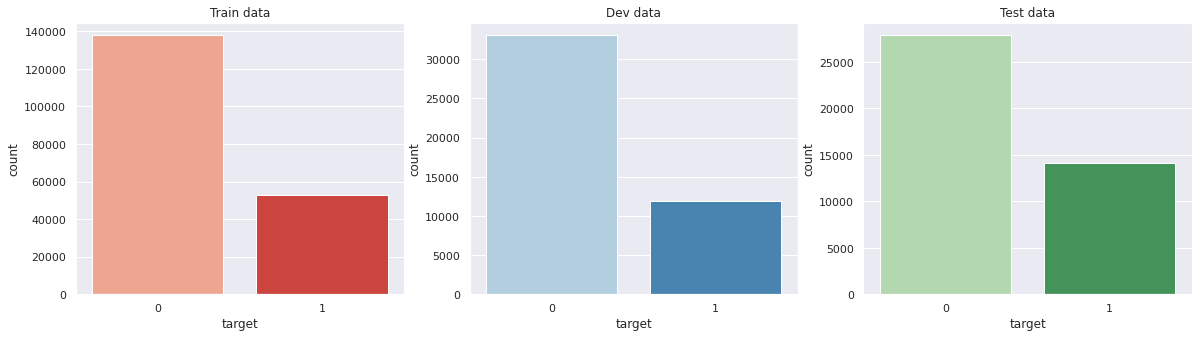

In [ ]:
# Visualize target distribution
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
sns.countplot(train_df.target, ax = ax[0], palette = 'Reds')
ax[0].set_title('Train data')
sns.countplot(dev_df.target, ax = ax[1], palette = 'Blues')
ax[1].set_title('Dev data')
sns.countplot(test_df.target, ax = ax[2], palette = 'Greens')
ax[2].set_title('Test data')

Insights
  
We can see that the test data has more cancer patches compared to healthy tissue patches than train or dev, which is not balanced. We should keep this in mind.

### 3.2 Creating pytorch image datasets



It's often a good idea to start as simple as possible and to grow more complex while iterating through the solution.
  
The simplest transformations we can do for each image are:
- Resizing the images to the desired input shape
- Performing horizontal and vertical flips

In our case, the patches are of shape (50, 50, 3) and we could set this as our input shape. As CNNs are translational but not rotational, it's a good idea to add flips during training. This way we can increase the variety of our data in a meaningful way as each patch could be rotated as well on the tissue slice. As we are not looking at the whole tissue, we are not loosing spatial connections between patches and it's not important that some neighboring patches are rotated in different directions.

In [15]:
# Define image transformation function
def my_transform(key = "train", plot = False):
  train_sequence = [transforms.Resize((50, 50)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip()]
  val_sequence = [transforms.Resize((50, 50))]
  if plot == False:
    train_sequence.extend([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_sequence.extend([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

  data_transforms = {'train': transforms.Compose(train_sequence), 'val': transforms.Compose(val_sequence)}
  return data_transforms[key]


We also need to create a dataset that loads an image patch of a patient, converts it to RGB, performs the augmentation if it's desired and returns the image, the target, the patient id and the image coordinates.

In [16]:
class BreastCancerDataset(Dataset):

  def __init__(self, df, transform = None):
    self.states = df
    self.transform = transform

  def __len__(self):
    return len(self.states)
  
  def __getitem__(self, idx):
    patient_id = self.states.patient_id.values[idx]
    x_coord = self.states.x.values[idx]
    y_coord = self.states.y.values[idx]
    image_path = self.states.path.values[idx]
    image = Image.open(image_path)
    image = image.convert('RGB')

    if self.transform:
      image = self.transform(image)
    
    if "target" in self.states.columns.values:
      target = np.int(self.states.target.values[idx])
    else:
      target = None
    
    return {"image": image,
            "label": target,
            "patient_id": patient_id,
            "x": x_coord,
            "y": y_coord}

In [17]:
train_dataset = BreastCancerDataset(train_df, transform = my_transform(key = "train"))
dev_dataset = BreastCancerDataset(dev_df, transform = my_transform(key = "val"))
test_dataset = BreastCancerDataset(test_df, transform = my_transform(key = "val"))

In [18]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

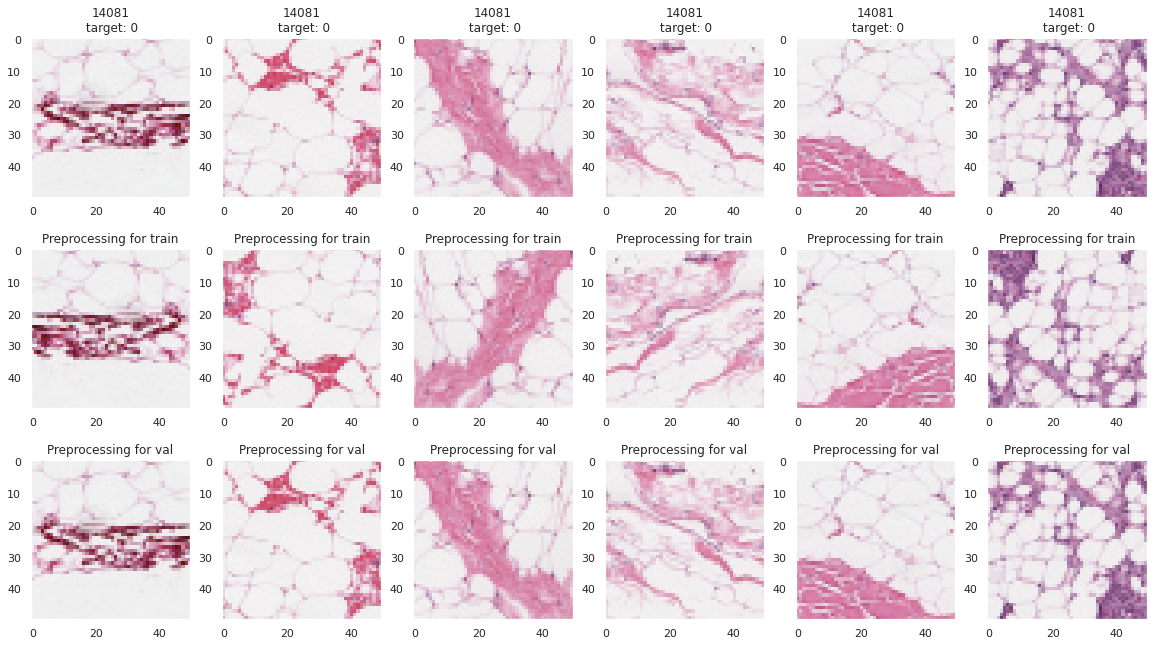

In [ ]:
# Visualize the augmentations
fig, ax = plt.subplots(3, 6, figsize = (20, 11))

train_transform = my_transform(key = "train", plot = True)
val_transform = my_transform(key = "val", plot = True)

for m in range(6):
  filepath = train_df.path.values[m]
  image = Image.open(filepath)
  ax[0, m].imshow(image)
  transformed_img = train_transform(image)
  ax[1, m].imshow(transformed_img)
  ax[2, m].imshow(val_transform(image))
  ax[0, m].grid(False)
  ax[1, m].grid(False)
  ax[2, m].grid(False)
  ax[0,m].set_title(train_df.patient_id.values[m] + "\n target: " + train_df.target.values[m])
  ax[1,m].set_title("Preprocessing for train")
  ax[2,m].set_title("Preprocessing for val")

### 3.3 Creating pytorch dataloaders

As the gradients for each learning step are computed over batches, we benefit from shuffling the training data after each epoch. This way each batch is composed differently and we don't start to learn for specific sequences of images. For validation and training, we drop the last batch that often consists less images than the batch size.

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
dev_dataloader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, drop_last = False)


In [20]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

6017 1380 1275


## **4. Set up the model**

### 4.1 Transfer Learning
- Why transfer learning? 

  Training a reasonable neural network would need approximately 300,000 image samples. Our dataset is very small and overfitting may exist.

- We use a pre-trained ResNet18 Convolutional Neural Net model, and apply transfer learning to learn weights of only the last layer of the network.

- First layers of a pretrained CNN extract basic features like edges and only last layers contain very problem specific features.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
# Settings
run_training = False
retrain = False
find_learning_rate = False

In [23]:
model = torchvision.models.resnet18(pretrained = False)

if run_training:
  model.load_state_dict(torch.load("/content/gdrive/My Drive/Breast_cancer_detection/pretrained-pytorch-models/resnet18-5c106cde.pth"))

num_features = model.fc.in_features
print(num_features)

512


In [24]:
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),

    nn.Linear(256, num_classes)

)

def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)
  
model.apply(init_weights)
model = model.to(device)

### 4.2 Set up the loss function

This is a binary classification problem. A common loss for this problems is the **binary cross entropy function**. Using it we could only use one single output neuron to make predictions. As I like to compute the f1-score during training and prediction and I need to compute false and true positives/negatives in a simple manner, I will use the **cross entropy loss with K=2 output neurons** or 2 classes that can be hot (1) or cold (0)

We can use the weights to deal with the class imbalance. In our case, we have much more negative (healthy) patches than those with cancer. To deal with this imbalance, we like to increase the impact of the gradients of positive cases during training and we can do so with a higher weight than for the negative cases.

In [25]:
weights = compute_class_weight(y = train_df.target.values, class_weight = "balanced", classes = train_df.target.unique())
class_weights = torch.FloatTensor(weights)

if device.type == "cuda":
  class_weights = class_weights.cuda()

print(class_weights)

tensor([0.7048, 1.7208], device='cuda:0')


In [26]:
train_df.target.unique()

array([0, 1], dtype=object)

In [27]:
criterion = nn.CrossEntropyLoss(weight = class_weights)

### 4.3 Set up the evaluation metric



The percentage of correct predictions (accuracy score) is not a good evaluation metric for imbalanced target distributions. A better choice will be f1-score.

**Precision and Recall**

*Recall: how many selected cases are positive?*

recall = TruePositives / (TruePositives + FalsePositives)

*Precision: how many positive cases are selected?*

precision = TruePositives / (TruePositives + FalseNegatives)


*f1 score is defined as the harmonic mean of precision and recall. Contrast to the arithmetic mean, it is shifted towards small outliers but not influenced strongly by large ones.*

f1 = 2 / ((1/recall) + (1/precision))


In [28]:
def f1_score(preds, targets):
  tp = (preds*targets).sum().to(torch.float32)
  fp = ((1 - targets)*preds).sum().to(torch.float32)
  fn = (targets*(1 - preds)).sum().to(torch.float32)

  epsilon = 1e-7
  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)

  f1_score = 2 * precision * recall / (precision + recall + epsilon)
  return f1_score

In [29]:
# Build the training loop
def train_loop(model, criterion, optimizer, lr_find = False, scheduler = None, num_epochs = 3, lam = 0.0):
  since = time.time()
  if lr_find:
    phases = ['train']
  else:
    phases = ['train', 'dev', 'test']
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  loss_dict = {'train': [], 'dev': [], 'test': []}
  lam_tensor = torch.tensor(lam, device = device)

  running_loss_dict = {'train': [], 'dev': [], 'test': []}

  lr_find_loss = []
  lr_find_lr = []
  smoothing = 0.2

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in phases:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      tk0 = tqdm(dataloaders[phase], total = int(len(dataloaders[phase])))
      
      counter = 0
      for bi, d in enumerate(tk0):
        inputs = d['image']
        labels = d['label']
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()

            #l2_reg = torch.tensor(0, device = device)
            #for param in model.parameters():
                #l2_reg = lam_tensor * torch.norm(param)
            #loss += l2_reg

            optimizer.step()
            # cyclical lr schedule is invoked after each batch
            if scheduler is not None:
              scheduler.step()
              if lr_find:
                lr_step = optimizer.state_dict()['param_groups'][0]['lr']
                lr_find_lr.append(lr_step)
                if counter == 0:
                  lr_find_loss.append(loss.item())
                else:
                  smoothed_loss = smoothing * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                  lr_find_loss.append(smoothed_loss)
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        counter += 1

        tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                         'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)
                         })
        running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))

      epoch_loss = running_loss / dataset_sizes[phase]
      loss_dict[phase].append(epoch_loss)
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'dev' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()  
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:.4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  results = {'model': model,
             'loss_dict': loss_dict,
             'running_loss_dict': running_loss_dict,
             'lr_find': {'lr': lr_find_lr,
                         'loss': lr_find_loss}}
  return results

### 4.4 Search for an optimal learning rate

The learning rate is one of the most important hyperparameters for tuning neural networks. A rate that is too high will lead to jumps to higher values in the training loss during optimization. If it's too small, the learning process is too slow and will probably stop too early in the case we have defined a minimum required loss change.

In [30]:
start_lr = 1e-6
end_lr = 0.1

In [31]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
  # max_iterations should be the number of steps within num_epochs_*epoch_iterations
  # this way the learning rate increases linearily within the period num_epochs*epoch_iterations
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer = optimizer,
                                                base_lr = min_lr,
                                                max_lr = max_lr,
                                                step_size_up = max_iterations,
                                                step_size_down = max_iterations,
                                                mode = 'triangular')
  return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
  # suggested_stepsize = 2*num_iterations_within_epoch
  stepsize_up = np.int(stepsize / 2)
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer = optimiser,
                                                base_lr = min_lr,
                                                max_lr = max_lr,
                                                step_size_up = stepsize_up,
                                                step_size_down = stepsize_up,
                                                mode = 'triangular')
  return scheduler

In [32]:
import math
model_path = '/content/gdrive/My Drive/Breast_cancer_detection/BreastCancerModel/'
losses_path = '/content/gdrive/My Drive/Breast_cancer_detection/BreastCancerModel/'

if find_learning_rate:
  lr_find_epochs = 1
  optimizer = optim.SGD(model.fc.parameters(), start_lr)
  scheduler = get_lr_search_scheduler(optimizer, start_lr, end_lr, lr_find_epochs * len(train_dataloader))
  results = train_loop(model, criterion, optimizer, lr_find = True, scheduler = scheduler, num_epochs = lr_find_epochs)
  lr_find_lr, lr_find_loss = results['lr_find']['lr'], results['lr_find']['loss']

  find_lr_df = pd.DataFrame(lr_find_loss, columns = ['smoothed loss'])
  find_lr_df.loc[:, 'lr'] = lr_find_lr
  find_lr_df.to_csv(model_path + 'learning_rate_search_own.csv', index = False)
else:
  find_lr_df = pd.read_csv(model_path + 'learning_rate_search.csv')

Text(0.5, 1.0, 'Searching for the optimal learning rate')

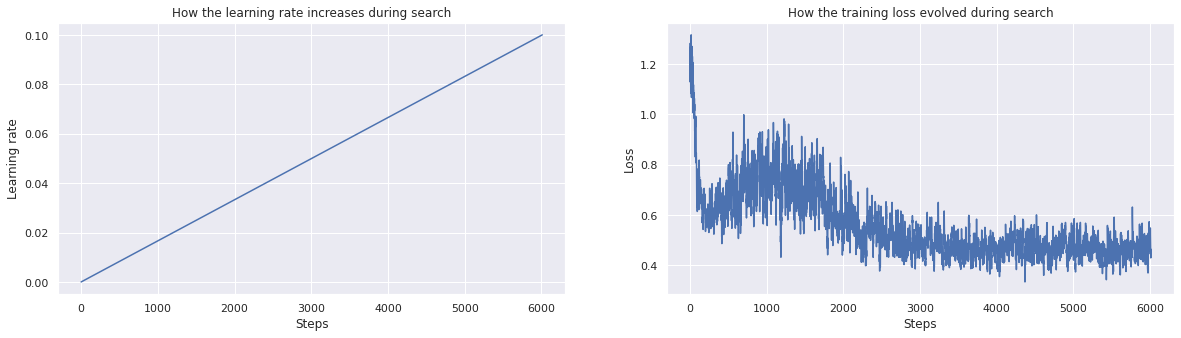

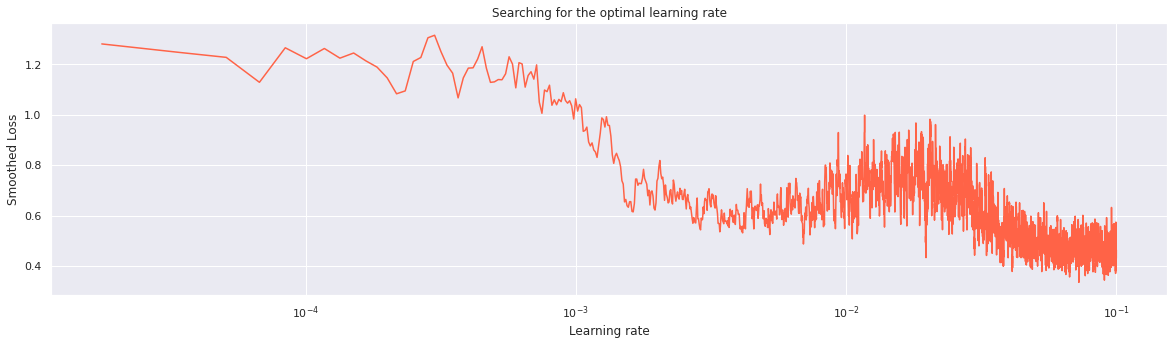

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ax[0].plot(find_lr_df.lr.values)
ax[1].plot(find_lr_df['smoothed loss'].values)
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Learning rate')
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Loss')
ax[0].set_title('How the learning rate increases during search')
ax[1].set_title('How the training loss evolved during search')

plt.figure(figsize = (20, 5))
plt.plot(find_lr_df.lr.values, find_lr_df['smoothed loss'].values, '-', color = 'tomato')
plt.xlabel('Learning rate')
plt.xscale('log')
plt.ylabel('Smoothed Loss')
plt.title('Searching for the optimal learning rate')


Insights
- The loss drops right from the start but increases after values higher than 0.005.
- Consequently we can set the minimum learning rate to 1e-6 and the maximum to 0.005.

In [33]:
start_lr = 1e-6
end_lr = 0.005

output_path = ''

## **5. Train the model or load the results**

In [ ]:
if run_training:
  num_epochs = 30
  optimizer = optim.SGD(model.fc.parameters(), lr = 0.01)
  scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*num_epochs)
  results = train_loop(model, criterion, optimizer, scheduler = scheduler, num_epochs = num_epochs)
  model, loss_dict, running_loss_dict = results['model'], results['loss_dict'], results['running_loss_dict']

  if device == 'cpu':
    output_path += 'own.pth'
  else:
    output_path += '_cuda_own.pth'
  
  torch.save(model.state_dict(), output_path)

  losses_df = pd.DataFrame(loss_dict['train'], columns = ['train'])
  losses_df.loc[:, 'dev'] = loss_dict['dev']
  losses_df.loc[:, 'test'] = loss_dict['test']
  losses_df.to_csv(losses_path + 'losses_breastcancer_own.csv', index = False)
  
  running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
  running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
  running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
  running_losses_df.to_csv("running_losses_breastcancer_own.csv", index=False)

else:
  if device == 'cpu':
    load_path = model_path + '.pth'
  else:
    load_path = model_path + '_cuda.pth'
  
  model.load_state_dict(torch.load(load_path, map_location = 'cpu'))
  model.eval()

  losses_df = pd.read_csv(losses_path + 'losses_breastcancer.csv')
  running_losses_df = pd.read_csv(losses_path + 'running_losses_breastcancer.csv')


Epoch 0/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.5134 Acc: 0.7699


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4320 Acc: 0.8126


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4350 Acc: 0.8092

Epoch 1/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4802 Acc: 0.7873


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4453 Acc: 0.8072


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4469 Acc: 0.8091

Epoch 2/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4692 Acc: 0.7941


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4176 Acc: 0.8198


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4236 Acc: 0.8153

Epoch 3/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4673 Acc: 0.7937


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4130 Acc: 0.8169


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4185 Acc: 0.8159

Epoch 4/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4617 Acc: 0.7974


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4687 Acc: 0.7796


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4756 Acc: 0.7809

Epoch 5/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4594 Acc: 0.7977


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4086 Acc: 0.8249


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4140 Acc: 0.8250

Epoch 6/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4563 Acc: 0.7993


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4076 Acc: 0.8184


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4143 Acc: 0.8168

Epoch 7/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4541 Acc: 0.8006


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4070 Acc: 0.8312


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4116 Acc: 0.8278

Epoch 8/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4526 Acc: 0.8019


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.3975 Acc: 0.8292


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.3986 Acc: 0.8290

Epoch 9/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4495 Acc: 0.8047


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4223 Acc: 0.8064


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4247 Acc: 0.8053

Epoch 10/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4490 Acc: 0.8032


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4043 Acc: 0.8231


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4090 Acc: 0.8218

Epoch 11/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4468 Acc: 0.8045


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4130 Acc: 0.8192


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4227 Acc: 0.8182

Epoch 12/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4440 Acc: 0.8065


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4111 Acc: 0.8321


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4170 Acc: 0.8270

Epoch 13/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4432 Acc: 0.8060


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.3843 Acc: 0.8371


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.3912 Acc: 0.8338

Epoch 14/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4430 Acc: 0.8076


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4107 Acc: 0.8208


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4153 Acc: 0.8198

Epoch 15/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4391 Acc: 0.8088


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.3973 Acc: 0.8284


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4052 Acc: 0.8255

Epoch 16/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4404 Acc: 0.8081


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.3950 Acc: 0.8293


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4013 Acc: 0.8273

Epoch 17/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4426 Acc: 0.8074


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4178 Acc: 0.8116


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4259 Acc: 0.8085

Epoch 18/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4387 Acc: 0.8091


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4221 Acc: 0.8078


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4261 Acc: 0.8067

Epoch 19/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4368 Acc: 0.8099


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4041 Acc: 0.8183


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4114 Acc: 0.8175

Epoch 20/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4380 Acc: 0.8104


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4309 Acc: 0.8009


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4375 Acc: 0.7994

Epoch 21/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4367 Acc: 0.8090


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4091 Acc: 0.8174


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4176 Acc: 0.8165

Epoch 22/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4366 Acc: 0.8103


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4064 Acc: 0.8184


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4144 Acc: 0.8154

Epoch 23/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4354 Acc: 0.8106


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4102 Acc: 0.8142


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4192 Acc: 0.8120

Epoch 24/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4365 Acc: 0.8114


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.3953 Acc: 0.8294


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4047 Acc: 0.8285

Epoch 25/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4327 Acc: 0.8123


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4117 Acc: 0.8129


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4200 Acc: 0.8090

Epoch 26/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4334 Acc: 0.8130


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4036 Acc: 0.8251


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4107 Acc: 0.8237

Epoch 27/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4345 Acc: 0.8118


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4058 Acc: 0.8282


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4153 Acc: 0.8242

Epoch 28/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4336 Acc: 0.8115


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.4017 Acc: 0.8223


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4064 Acc: 0.8218

Epoch 29/29
----------


  0%|          | 0/6012 [00:00<?, ?it/s]

train Loss: 0.4309 Acc: 0.8138


  0%|          | 0/1381 [00:00<?, ?it/s]

dev Loss: 0.3984 Acc: 0.8287


  0%|          | 0/1279 [00:00<?, ?it/s]

test Loss: 0.4032 Acc: 0.8270

Training complete in 181m 57s
Best val Acc: 0.8371


In [34]:
if run_training:
  num_epochs = 30
  optimizer = optim.SGD(model.fc.parameters(), lr = 0.01)
  scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*num_epochs)
  results = train_loop(model, criterion, optimizer, scheduler = scheduler, num_epochs = num_epochs)
  model, loss_dict, running_loss_dict = results['model'], results['loss_dict'], results['running_loss_dict']

  if device == 'cpu':
    output_path += 'own.pth'
  else:
    output_path += '_cuda_own.pth'
  
  torch.save(model.state_dict(), output_path)

  losses_df = pd.DataFrame(loss_dict['train'], columns = ['train'])
  losses_df.loc[:, 'dev'] = loss_dict['dev']
  losses_df.loc[:, 'test'] = loss_dict['test']
  losses_df.to_csv(losses_path + 'losses_breastcancer_own.csv', index = False)
  
  running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
  running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
  running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
  running_losses_df.to_csv("running_losses_breastcancer_own.csv", index=False)

else:
  if device == 'cpu':
    load_path = model_path + '.pth'
  else:
    load_path = model_path + '_cuda.pth'
  
  model.load_state_dict(torch.load(load_path, map_location = 'cpu'))
  model.eval()

  losses_df = pd.read_csv(losses_path + 'losses_breastcancer.csv')
  running_losses_df = pd.read_csv(losses_path + 'running_losses_breastcancer.csv')

## **6. Exploring results and errors**


### 6.1 Loss convergence

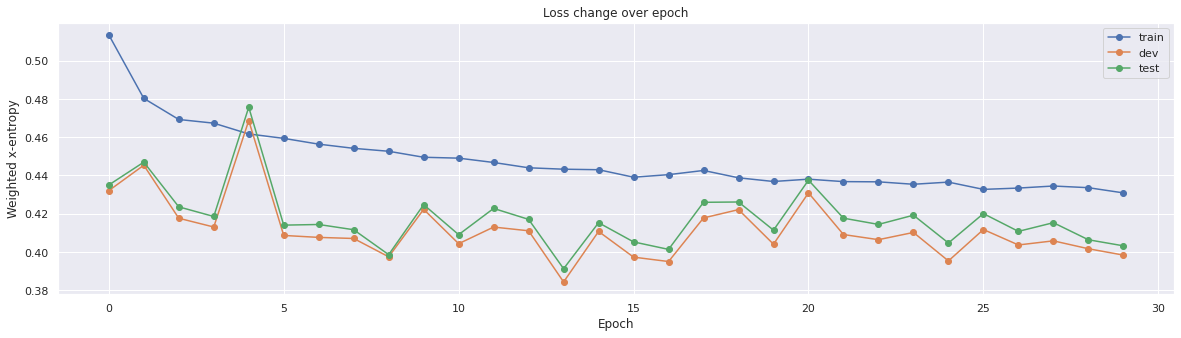

In [ ]:
plt.figure(figsize = (20, 5))

plt.plot(losses_df['train'], '-o', label = 'train')
plt.plot(losses_df['dev'], '-o', label = 'dev')
plt.plot(losses_df['test'], '-o', label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Weighted x-entropy')
plt.title('Loss change over epoch')
plt.legend()

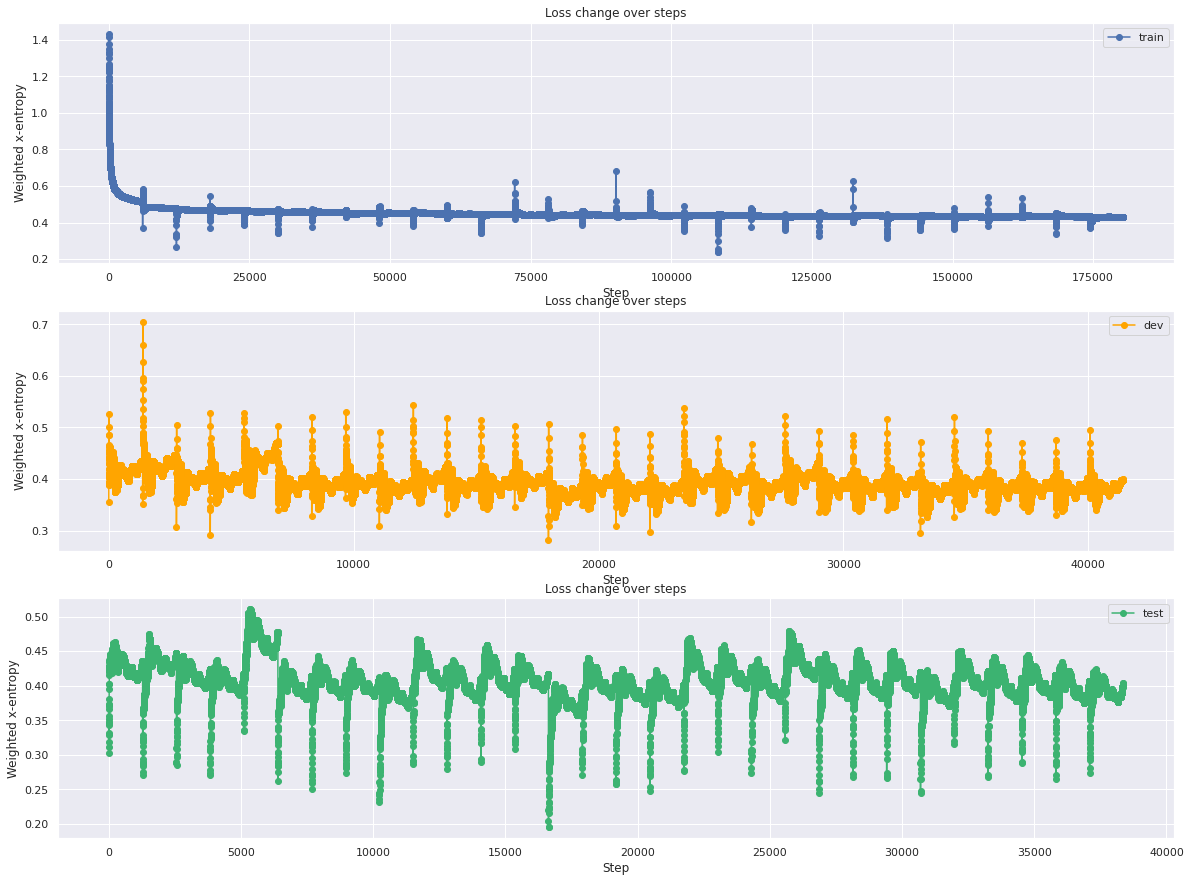

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15))

ax[0].plot(running_losses_df['train'], '-o', label = 'train')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Weighted x-entropy')
ax[0].set_title('Loss change over steps')
ax[0].legend()

ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Weighted x-entropy")
ax[1].set_title("Loss change over steps")
ax[1].legend()

ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Weighted x-entropy")
ax[2].set_title("Loss change over steps")
ax[2].legend()

In [35]:
def sigmoid(x):
  return 1./(1 + np.exp(-x))

def evaluate_model(model, predictions_df, key):
  was_training = model.training
  model.eval()

  with torch.no_grad():
    for i, data in enumerate(dataloaders[key]):
      inputs = data['image'].to(device)
      labels = data['label'].to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      proba = outputs.cpu().numpy().astype(np.float)
      predictions_df.loc[i*batch_size : (i+1)*batch_size-1, 'proba'] = sigmoid(proba[:, 1])
      predictions_df.loc[i*batch_size : (i+1)*batch_size-1, 'true'] = data['label'].numpy().astype(np.int)
      predictions_df.loc[i*batch_size : (i+1)*batch_size-1, 'predicted'] = preds.cpu().numpy().astype(np.int)
      predictions_df.loc[i*batch_size:(i+1)*batch_size-1, "x"] = data["x"].numpy()
      predictions_df.loc[i*batch_size:(i+1)*batch_size-1, "y"] = data["y"].numpy()
      predictions_df.loc[i*batch_size:(i+1)*batch_size-1, "patient_id"] = data["patient_id"]

  predictions_df = predictions_df.dropna()
  return predictions_df


In [36]:
if run_training:
  dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes['dev']), columns = ['true', 'predicted', 'proba'])
  test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes['test']), columns = ['true', 'predicted', 'proba'])

  dev_predictions = evaluate_model(model, dev_predictions, 'dev')
  test_predictions = evaluate_model(model, test_predictions, 'test')

  dev_predictions.to_csv("dev_predictions_own.csv", index=False)
  test_predictions.to_csv("test_predictions_own.csv", index=False)

else:
  dev_predictions = pd.read_csv(losses_path + 'dev_predictions.csv')
  test_predictions = pd.read_csv(losses_path + "test_predictions.csv")
  dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

In [37]:
test_predictions

true  predicted     proba       x       y  patient_id
0         0          0  0.128713  1201.0  2401.0       12906
1         0          0  0.347586   151.0  1001.0       12906
2         0          0  0.175564  1301.0  1251.0       12906
3         0          0  0.103502  1351.0   551.0       12906
4         0          0  0.224504   601.0  1551.0       12906
...     ...        ...       ...     ...     ...         ...
39600     1          1  0.680131  1651.0   701.0       14304
39601     1          1  0.814124  1201.0   851.0       14304
39602     1          0  0.551968  1201.0   901.0       14304
39603     1          1  0.894965   851.0   101.0       14304
39604     1          1  0.948164  1401.0  1151.0       14304

[39605 rows x 6 columns]

In [51]:
# True positives
TP = ((test_predictions['true'] == 1) & (test_predictions['predicted'] == 1)).sum()

# False positives
FP = ((test_predictions['true'] == 0) & (test_predictions['predicted'] == 1)).sum()

# True negatives
TN = ((test_predictions['true'] == 0) & (test_predictions['predicted'] == 0)).sum()

# False negatives
FN = ((test_predictions['true'] == 1) & (test_predictions['predicted'] == 0)).sum()

In [52]:
# Manually calculate performance metrics
recall = TP / (TP + FP)
precision = TP / (TP + FN)

f1 = 2 / ((1 / recall) + (1 / precision))

In [38]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
  transdict = {1: 'cancer', 0: 'no cancer'}
  y_t = np.array([transdict[x] for x in y_true])
  y_p = np.array([transdict[x] for x in y_pred])

  labels = ['no cancer', 'cancer']
  index_labels = ['actual no cancer', 'actual cancer']
  col_labels = ['predicted no cancer', 'predicted cancer']
  confusion = confusion_matrix(y_t, y_p, labels = labels)
  confusion_df = pd.DataFrame(confusion, index = index_labels, columns = col_labels)
  
  for n in range(2):
    confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis = 1).iloc[n]
  
  return confusion_df

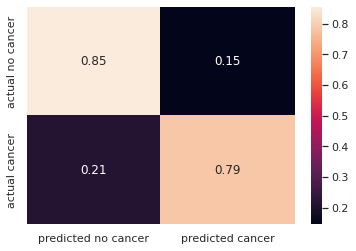

In [39]:
# Visualization for confusion_matrix
import seaborn as sn
confusion_df = get_confusion_matrix(test_predictions['true'], test_predictions['predicted'])
sn.heatmap(confusion_df, annot = True)

In [41]:
# Calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
bal_acc=balanced_accuracy_score(test_predictions['true'], test_predictions['predicted'])

print(bal_acc)

0.8205797678808686


### 6.2 Visualize prediction results

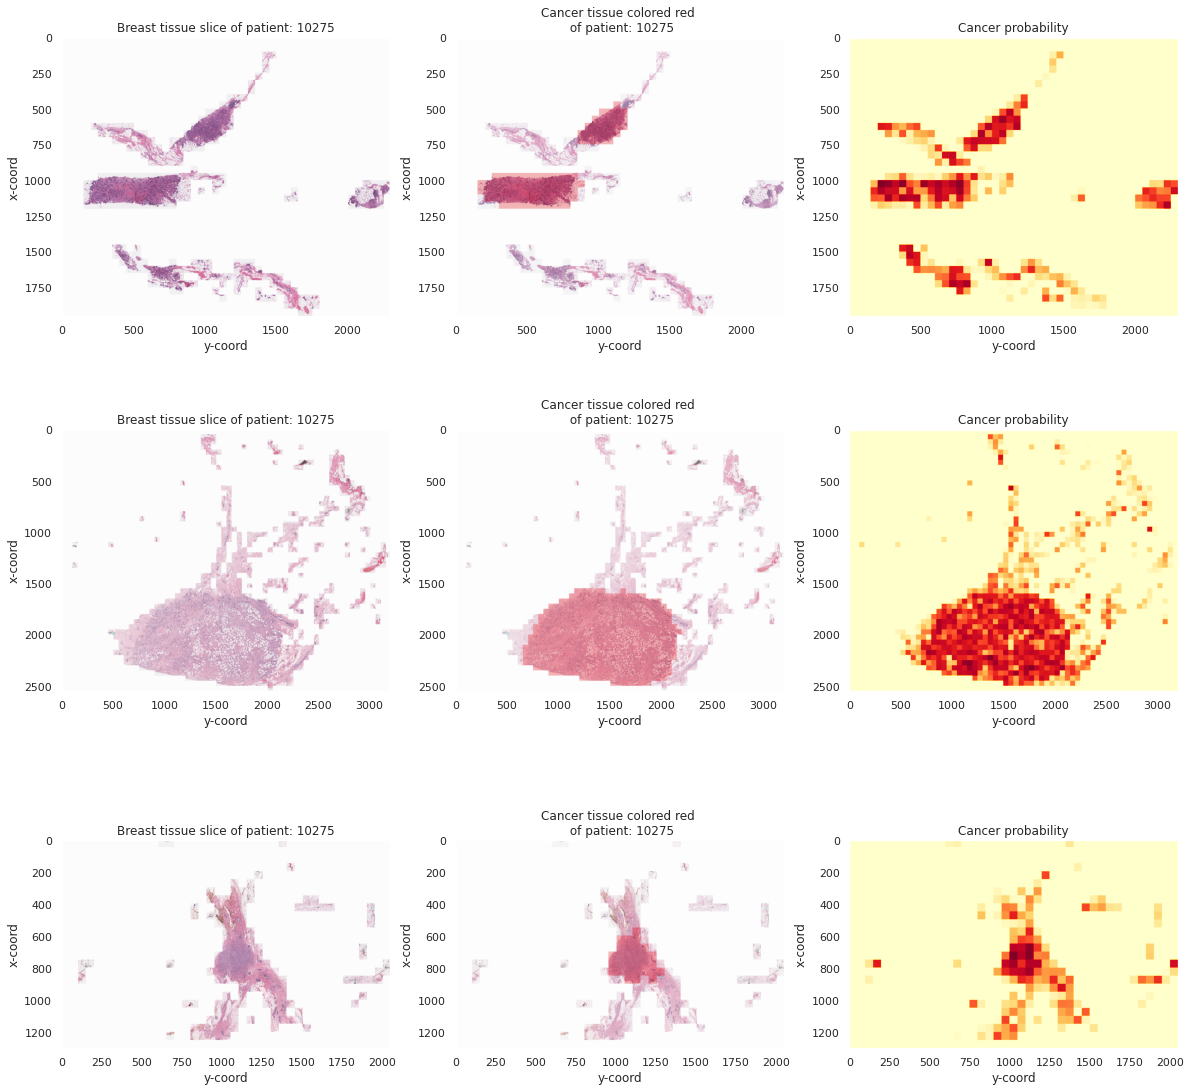

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (20, 20))

for n in range(3):
  idx = dev_predictions.patient_id.unique()[n]
  grid, mask, broken_patches, mask_proba = visualise_breast_tissue(idx, pred_df=dev_predictions)

  ax[n, 0].imshow(grid, alpha = 0.9)
  ax[n, 1].imshow(mask, alpha = 0.8)
  ax[n, 1].imshow(grid, alpha = 0.7)
  ax[n, 2].imshow(mask_proba[:,:,0], cmap = "YlOrRd")

  for m in range(3):
    ax[n, m].set_xlabel('y-coord')
    ax[n, m].set_ylabel('x-coord')
    ax[n, m].grid(False)
  
  ax[n, 0].set_title("Breast tissue slice of patient: " + patient_id)
  ax[n, 1].set_title("Cancer tissue colored red \n of patient: " + patient_id)
  ax[n, 2].set_title("Cancer probability")



### 6.3 Detailed analysis


In [ ]:
dev_predictions.head()

true  predicted     proba       x       y patient_id
0     0          0  0.003411   501.0  2001.0       9135
1     0          0  0.111403  1251.0   501.0       9135
2     0          0  0.234970   351.0   351.0       9135
3     0          0  0.599228   351.0  1051.0       9135
4     0          0  0.096663  1401.0   151.0       9135

Text(0.5, 1.0, 'Predicted probability of cancer in test')

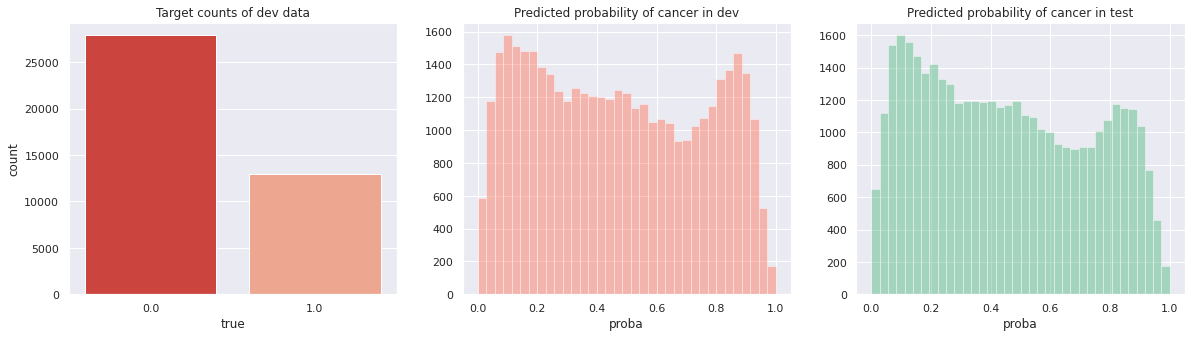

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

sns.countplot(dev_predictions.true.astype(np.float), ax=ax[0], palette="Reds_r")
ax[0].set_title("Target counts of dev data")

sns.distplot(dev_predictions.proba.astype(np.float), ax=ax[1], kde=False, color="tomato")
ax[1].set_title("Predicted probability of cancer in dev")

sns.distplot(test_predictions.proba.astype(np.float), ax=ax[2], kde=False, color="mediumseagreen")
ax[2].set_title("Predicted probability of cancer in test")